# 多項式近似

- これまでは、次期の価値関数や政策関数を近似するのに、線形補間やスプライン補間を用いた

- これらの補間は、いずれも状態空間を分割するグリッドの間を異なる関数で近似するが、今度は状態空間全体を一つの多項式(polynomial)で近似する

- いま、

$$
  y=g(x)=\frac{1}{1+x^{2}}, x \in [-5,5]
$$

が我々が知りたい真の関数であるとする

- しかし、我々はその真の姿を知らず、11個の点の情報だけを持っているとしよう

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib #matplolibで日本語を表示させるためのモジュール。インストールしていない場合は、!pip install japanize_matplotlib でインストールする・
from scipy.interpolate import interp1d

In [2]:
def f(x0):
    """
    ------------------
    === ルンゲ関数 ===
    ------------------
    """
    nx = x0.size
    f0 = np.ones(nx) / (np.ones(nx)+25*x0**2)

    return f0

In [3]:
#データ点
xmin = -1
xmax = 1
nxd = 11
xd = np.linspace(xmin,xmax,nxd)
yd = f(xd)

#関数による値
nx = 1001
x0 = np.linspace(xmin,xmax,nx)
y0 = f(x0)

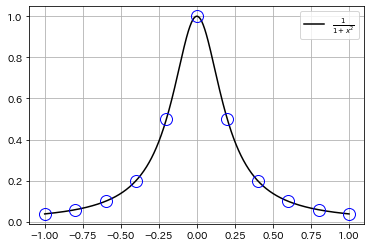

In [4]:
fig, ax = plt.subplots()
ax.plot(x0,y0,c="k",lw=1.5,label=r"$\frac{1}{1+x^{2}}$")
ax.plot(xd, yd, "o", mfc="none", mec="b",markersize=12,lw=2)
ax.legend(loc="upper right")
ax.grid()
plt.show()

In [5]:
#Python関数(scipy.interpolate.interp1d)を使った線形補間による近似
x1 = np.linspace(xmin,xmax,nx)
#(xd,yd)による線形補間した関数を定義する
#Matlab関数(interp1)は補間と評価を1つの関数で行うが、interp1d関数では補間と評価を別々に行う。
interp_y1 = interp1d(xd,yd,kind="linear",fill_value="extrapolate") 
y1 = interp_y1(x1)

#通常の多項式による近似
Xd = np.ones((nxd,nxd))
X2 = np.ones((nx,nxd))
x2 = x1
for i in range(nxd-1):
    Xd[:,i+1] = xd**(i+1)
    X2[:,i+1] = x2**(i+1)

b = (np.linalg.inv(Xd.T @ Xd)) @ (Xd.T @ yd)
y2 = X2 @ b

# size(Xd)
# rcond(Xd)

- この11個の点を線形補間を使って近似すると下図の太線のようになる

- 点と点の間を直線で結んでいるため、点の上で屈折しており、微分不可能になっている

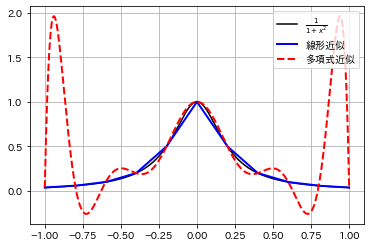

In [6]:
fig, ax = plt.subplots()
ax.plot(x0,y0,c="k",ls="-",lw=1.5,label=r"$\frac{1}{1+x^{2}}$")
ax.plot(x1,y1,c="b",ls="-",lw=2.0,label="線形近似")
ax.plot(x2,y2,c="r",ls="--",lw=2.0,label="多項式近似")
ax.legend(loc="upper right")
ax.grid()
plt.show()

- 一方、次のような10次の多項式を用いて11個の点の間を補間する

$$
  g(x;\mathbb{\theta}) = \theta_{0}+\theta_{1}x+\theta_{2}x^{2}+\cdots+\theta_{10}x^{10}
$$

ここで、11つの未知の係数に対して11個の点の情報を用いて係数の値を求めることができる

- しかし、多重共線性(multicollinearity)などから、とくにグラフの両端において多項式の近似の精度はよくない

## チェビシェフ多項式

- 通常の多項式の代わりによく用いられるのが、チェビシェフ多項式(Chebyshev polinomial)である

$$
  g(x;\mathbb{\theta}) = \theta_{0}+\theta_{1}T_{1}(x)+\theta_{2}T_{2}(x)+\cdots+\theta_{N-1}T_{N-1}(x)
$$

$T_{i}(x):[-1,1]\rightarrow[-1,1]$ for $i=1,2,...,N-1$は基底関数(basis function)と呼ばれる

- 基底関数は次のように再帰的に書ける

\begin{align*}
  T_{0}(x) &= 1, \\
  T_{1}(x) &= x, \\
  T_{2}(x) &= 2x^{2}-1, \\
  \vdots & \\
  T_{N-1}(x) &= 2xT_{N-2}(x)-T_{N-3}(x), \\
\end{align*}

- チェビシェフ多項式をデータにフィットさせてパラメータ$\mathbb{\theta}=[\theta_{0},...,\theta_{N-1}]$を求めるには、N個の評価点$x_{j},j=0,1,...,N-1$を用いる

- 評価点には2種類ある

チェビシェフゼロ点(Chebyshev zeros)：$T_{N-1}(x)=0$の解および$x_{0}=0$

\begin{align*}
  x_{0} &= 0, \\
  x_{j} &= \cos\big(\frac{(2j-1)\pi}{2(N-1)}\big)
\end{align*}

チェビシェフ極値点(Chebyshev extrema)：$|T_{N-1}(x)|=1$の解

$$
  x_{j} = \cos\big(\frac{j\pi}{N-1}\big)
$$

In [7]:
def polygrid(kmin,kmax,N):
    """
    -----------------------------------------------
    === チェビシェフ多項式における評価点を返す関数 ===
    -----------------------------------------------
    <input>
    ・kmin: 状態変数のグリッドの最小値
    ・kmax: 状態変数のグリッドの最大値
    ・N: 状態変数のグリッド数
    <output>
    ・k: 状態変数のグリッド
    """
    #チェビシェフ極値点
    temp = np.linspace(0,N-1,N)
    x = -np.cos((np.pi/(N-1))*temp)

    #チェビシェフゼロ点
    #x = -np.cos((np.pi/2/(N-1))*(2*temp-1))
    #x[0] = 0.0

    #x([-1,1])からk([kmin,kmax])に変換
    k = 0.5*(kmax-kmin)*(x+1) + kmin

    return k

In [8]:
def polybas(kmin,kmax,Np,kgrid):
    """
    ----------------------------------------
    === 基底関数の行列を再帰的に求める関数 ===
    ----------------------------------------
    <input>
    ・kmin: 状態変数のグリッドの最小値
    ・kmax: 状態変数のグリッドの最大値
    ・Np: 多項式の次数-1   
    ・kgrid: 状態変数のグリッド(Ng個)
    <output>
    ・T: 基底関数の行列(NgxNp)
    (Ng個の評価点でNp-1次のチェビシェフ多項式で近似する)
    """
    Ng = len(kgrid) #グリッドの数
    x = (2/(kmax-kmin)) * (kgrid-kmin) - 1 #グリッドを[-1,1]の範囲に変換

    #基底関数の行列(NgxNp)を再帰的に求める
    T = np.zeros((Ng,Np))
    T0 = np.ones(Ng)
    T1 = x
    T2 = 2*x*T1 - T0
    T[:,0] = T1
    T[:,1] = T2

    for i in range(2,Np-1):
        T[:,i] = 2*x*T[:,i-1] - T[:,i-1]
    
    T = np.hstack([T0.reshape((Ng,1)),T[:,0:Np-1]])
    #np.linspaceで返されるベクトル(T0)は(Ng,)と1次元である。
    #このベクトルを行列に結合させるためにベクトルT0を(Ng,1)の2次元配列に変換している。 

    return T

- 通常の多項式と異なり、チェビシェフ多項式は、関数の値が空間を満遍なく覆っていることがわかる

In [9]:
# % x = linspace(-1,1,101)';

# % % % ordinary polynomial
# % % figure;
# % % plot(x,x.^2,'k-','LineWidth',1.0);
# % % hold on;
# % % plot(x,x.^4,'k--','LineWidth',1.0);
# % % plot(x,x.^8,'k:','LineWidth',1.0);
# % % legend('x^2','x^4','x^8');
# % % axis square;
# % % set(gca,'Fontsize',16);
# % %saveas (gcf,'ordipoly.eps','epsc2');
# % %print -depsc2 ordipoly.eps

# % % Chebyshev polynomial
# % T = polybas(-1,1,9,x);

# % figure;
# % plot(x,T(:,3),'k-','LineWidth',1.0);
# % hold on;
# % plot(x,T(:,5),'k--','LineWidth',1.0);
# % plot(x,T(:,9),'k:','LineWidth',1.0);
# % plot([-1 1],[0 0],'r-');
# % legend('T_2(x)','T_4(x)','T_8(x)');
# % axis square;
# % set(gca,'Fontsize',16);
# % %saveas (gcf,'chebpoly.eps','epsc2');

- 評価点$x_{j}$とその点における関数の値$g(x_{j})$がわかると、多項式$g(x_{j};\mathbf{\theta})$を関数の値にフィットさせることで、パラメータ$\mathbf{\theta}$が得られる

$$
  \left[\begin{array}{c} g(x_{0}) \\ g(x_{1}) \\ \vdots \\ g(x_{N-1}) \end{array}\right]
  = \left[\begin{array}{ccccc} 1 & T_{1}(x_{0}) & T_{2}(x_{0}) & \cdots & T_{N-1}(x_{0}) \\
   1 & T_{1}(x_{1}) & T_{2}(x_{1}) & \cdots & T_{N-1}(x_{1}) \\
   \vdots & \vdots & \vdots & \ddots & \vdots \\
   1 & T_{1}(x_{N-1}) & T_{2}(x_{N-1}) & \cdots & T_{N-1}(x_{N-1})
   \end{array}\right]
   \left[\begin{array}{c} \theta_{0} \\ \theta_{1} \\ \vdots \\ \theta_{N-1} \end{array}\right]
$$

または、

$$
  g(\mathbf{x}) = T(\mathbf{x})\mathbf{\theta}
$$

ここで、$\mathbf{x}=[x_{0},\dots,x_{N-1}]$である。もし行列$T(\mathbf{x})$が正則であれば、$\mathbf{\theta} = T(\mathbf{x})^{-1}g(\mathbf{x})$が求まる

- 行列$T(\mathbf{x})$が非正則に近い悪条件(ill-conditioned)になる場合、逆行列の計算結果に含まれる誤差が大きくなる


- しかし、チェビシェフ基底関数とその評価点によって作られる行列は直交条件を満たし、正則になることが知られている


- また、行列$T(\mathbf{x})$は、ひとたび基底関数と評価点を選ぶとその後は固定される


- 逆行列$T(\mathbf{x})^{-1}$の計算をアルゴリズムの初期にあらかじめ行っておくことで、計算時間を節約できる

- 一般的な関数$g(k):[k_{1},k_{N}] \rightarrow \mathbb{R}$をチェビシェフ多項式で近似したい場合、以下の変換$\varphi(k):[k_{1},k_{N}] \rightarrow [-1,1]$を用いる

$$
  x_{j} = \varphi(k_{j}) = \frac{2(k_{j}-k_{1})}{k_{N}-k_{1}}-1
$$

そして以下のような多項式を得る

$$
  g(k;\mathbb{\theta}) = \theta_{0}+\theta_{1}T_{1}(\varphi(k))+\theta_{2}T_{2}(\varphi(k))+\cdots+\theta_{N-1}T_{N-1}(\varphi(k))
$$

- チェビシェフ多項式と評価点を用いた近似で、通常の多項式と等間隔のグリッドを用いた近似に比べて、近似の精度が改善している

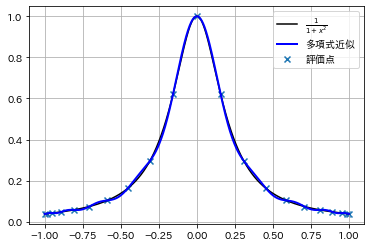

In [11]:
#チェビシェフ多項式による近似
nxd=21
xcheb = polygrid(xmin,xmax,nxd)
ycheb = f(xcheb)
T = polybas(xmin,xmax,nxd,xcheb)

theta = np.linalg.inv(T) @ ycheb

x3 = x1
T3 = polybas(xmin,xmax,nxd,x3)
y3 = T3@theta 

fig, ax = plt.subplots()
ax.plot(x0,y0,c="k",ls="-",lw=1.5,label=r"$\frac{1}{1+x^{2}}$")
ax.plot(x3,y3,c="b",ls="-",lw=2.0,label="多項式近似")
ax.scatter(xcheb,ycheb,marker="x",label="評価点")
ax.legend(loc="upper right")
ax.grid()
plt.show()